###**Training Logistic Regression Model on the Data**

*Team Members: Mingyuan Ma, Shuyao Zhou, Yuanrui Zhu*

L2-regularized logistic regression for binary or multiclass classification; trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals and prints out the strongest coefficients for each class.

---Introduction---

We use a bigram + trigram model instead of BoW to conduct feature engineering. On top of that, we concluded approximately 50 common words which are strong signs of casualness and give features containing those words a higher weight. We also deal with emojis by converting them to words so they would be taken into account within the bigram model (instead of being deleted thus losing the predictive power). 

---Code---

In [ ]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm

In [ ]:
# If you have your folder of data on your Google drive account, you can connect that here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change this to the directory with your data
directory="/content/drive/MyDrive/ap_data"#/43

In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[1].lstrip().rstrip()
            text = cols[2]

            X.append(text)
            Y.append(label)

    return X, Y


In [ ]:
class Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

        self.predict = [] 

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)
        
        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
        
        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

            # print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model

        

    def test(self):
        predict = self.log_reg.predict(self.testX)
        self.predict = predict
        return self.log_reg.score(self.testX, self.testY)
        


    def get_predict(self): 
        return self.predict



    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (int(cat)-1, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (int(cat)-1, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (int(cat)-1, weight, feature))
              print()

            

In [ ]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats



In [ ]:
!pip install emot
# please run this for the first time

     |████████████████████████████████| 61 kB 2.1 kB/s 


In [ ]:
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
import re

def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text


def weighted_convoluation_featurize(text):

    feats = {}
    text = convert_emojis(text)
    
    words = nltk.word_tokenize(text)

    # feats["smaller-than-10"] = 1 if len(words) <=10 else 0
    # feats["smaller-than-50"] = 1 if len(words) <=50 and len(words) >10 else 0
    # feats["larger-than-50"] = 1 if len(words) >50 else 0

    pointer1, pointer2 = 0, 0

    casual = ["oh","cool","!", "!!", "!!!", "tbh", "btw", "lmao", "asap", "wow", "somehow",
              "awesome", ":)", ":(", ": )", "...", "......", "fuck", "shit", "damn", "legit", "gotta",
              "absolutely", "extremely", "definitely", "hate", "right", "dude", "idk", "Idk"
              "could’ve", "how’s", "I’d", "let’s", "ma’am", "might’ve", "mustn’t", "gunna"
              "needn’t", "not’ve", "o’cloc", "there’d", "there’d", "there’s", "they’d", "wrong", "subs",
              "they’re", "we’d", "gonna", "wanna", "probably", "pitbull", "piss", "pisses"
              "when’s", "where’d", "where’s", "where’ve", "who’ll", "who’s", "?", "smiling_face️", 
              "face_with_tears_of_joy", "smiling_face_with_sunglasses", "loudly_crying_face", "absolutely",
              "sleeping_face", "grinning_face_with_smiling_eyes", "winking_face_with_tongue", "love"
              "grinning_face", "grinning_squinting_face", "grinning_face_with_sweat", "face_blowing_a_kiss",
              "smiling_face_with_heart-eyes", "persevering_face", "face_with_steam_from_nose", 
              "face_vomiting", "thumbs_up victory_hand️"]

    def getWeights(combo):
      weight = 1
      for cas in casual:
        if cas in combo:
          weight *= 1.2
      return weight

    for word in words:
      word=word.lower()
      feats[word]=getWeights(word)  
    
    if len(words) >= 2:
      while pointer1 != len(words) - 1:
        adjacent = words[pointer1 + 1]
        feats[words[pointer1] + " " + adjacent] = 1
        pointer1 += 1

    if len(words) >= 3:
      while pointer2 != len(words) - 2:
        adjacent = words[pointer2 + 1]
        far = words[pointer2 + 2]

        combo2 = words[pointer2] + " " + adjacent + " "
        combo3 = words[pointer2] + " " + adjacent + " " + far

        feats[combo2] = getWeights(combo2)
        feats[combo3] = getWeights(combo3)

        pointer2 += 1


    return feats

In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def run(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)
    
    simple_classifier = Classifier(weighted_convoluation_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    y_pred = simple_classifier.get_predict()
   

    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    print("The Strongest coefficients for each class are: ")
    simple_classifier.printWeights()
    return y_pred, testY, testX, trainY, trainX
    


In [ ]:
gid=0
trainingFile = "%s/train.txt" % directory
devFile = "%s/dev.txt" % directory
testFile = "%s/test.txt" % directory
    
y_pred, testY, testX, trainY, trainX = run(trainingFile, devFile, testFile)


Test accuracy for best dev model: 0.575, 95% CIs: [0.506 0.644]

The Strongest coefficients for each class are: 
0	0.753	!
0	0.409	i
0	0.244	?
0	0.232	...
0	0.195	me
0	0.170	my
0	0.169	: )
0	0.161	'm
0	0.154	with
0	0.146	na

1	0.236	if
1	0.176	If you 
1	0.176	If you
1	0.175	r/52book
1	0.154	literature
1	0.151	bookclub
1	0.147	maybe
1	0.144	found
1	0.140	then
1	0.139	have

2	0.233	as
2	0.228	by
2	0.228	be
2	0.222	r/truelit
2	0.210	's
2	0.194	.
2	0.182	are
2	0.179	on
2	0.167	/r/truelit
2	0.164	/r/askliterarystudies

3	0.151	but
3	0.150	. But 
3	0.150	. But
3	0.146	love
3	0.142	of
3	0.098	one
3	0.093	dark
3	0.091	world
3	0.087	diaries
3	0.085	her , 



This result is much better than the performance of the majority class classifier (0.45) and BoW L2 LogReg (0.51).


---END OF PART A---

\pagebreak


###**Analysis Report**

*Team Members: Mingyuan Ma, Shuyao Zhou, Yuanrui Zhu*

Use the model you've trained on your data to tell us something about the phenomenon you've annotated.

**Part 1: Label Mistaken Identification Using Confusion Matrix & Rethinking Category Boundaries**

Text(33.0, 0.5, 'True labels')

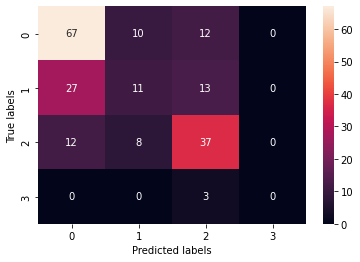

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.heatmap(confusion_matrix(testY, y_pred), annot = True, fmt = 'd')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [ ]:
# Class 0
class0_precision = 67 / (67 + 27 + 12)
class0_recall = 67 / (67 + 10 + 12)
class0_f1 = 2 * class0_precision * class0_recall / (class0_precision + class0_recall)

print("Class 0 precision is %.3f, recall is %.3f f1 score is %.3f" % (class0_precision, class0_recall, class0_f1))

Class 0 precision is 0.632, recall is 0.753 f1 score is 0.687


In [ ]:
# Class 1
class1_precision = 11 / (11 + 10 + 8)
class1_recall = 10 / (27 + 10 + 13)
class1_f1 = 2 * class1_precision * class1_recall / (class1_precision + class1_recall)

print("Class 1 precision is %.3f, recall is %.3f f1 score is %.3f" % (class1_precision, class1_recall, class1_f1))

Class 1 precision is 0.379, recall is 0.200 f1 score is 0.262


In [ ]:
# Class 2
class2_precision = 37 / (37 + 12 + 13 + 3)
class2_recall = 37 / (37 + 12 + 8)
class2_f1 = 2 * class2_precision * class2_recall / (class2_precision + class2_recall)

print("Class 2 precision is %.3f, recall is %.3f f1 score is %.3f" % (class2_precision, class2_recall, class2_f1))

Class 2 precision is 0.569, recall is 0.649 f1 score is 0.607


We plotted the confusion matrix comparing each class of actual and predicted test results, and accordingly calculated the **Precision, Recall and F-1** score for each of the four classes. 
	


*   For Class 0 (Casual), precision = 0.632, recall = 0.753, F1 = 0.687
*   For Class 1 (Ordinary), precision = 0.379, recall = 0.2, F1 = 0.262

*   For Class 2 (Formal), precision = 0.569, recall = 0.649, F1 = 0.607
*   For Class 3 (Artistic), precision = recall = F1= 0












Anlysis on statistics:

1. All the classes have the high or low precision and recall at the same time, so clearly there's a gap of performance among all the classes.
2. The performance of Casual and Formal is much more better than Ordinary, which follows the general case that Ordinary class is a lot more difficult to classify than the other two classes. However when judging a text to be in class 1, we may involve our personal judgement based on our unique educational and multilingual background. Hence, we're not judging based on the same metrics as machine, and it's normal for machine not capturing these factors and perform badly.
3. The score of Casual is the highest among all the classes, which is largely due to the apparent feature it demonstrates to readers (as we stated in guideline).  
4. We observed that the logistic model tend to classify real Class 1 to Class 0 or Class 2, since the precision for Class 1 is greater than its recall, which is the opposite case for Class 0 and Class 2. Given for the recall, real Y is in the denominator position, we can infer Class 1 has bearly no apparent features that can be relied on. 
5. Because of the uneven nature of our dataset, precision and recall all zero for Class 3, which we will conduct further discussion in the follow parts.

From the data set we can clearly conclude that Class 1 (Ordinary) is often mistaken for Class 0 (Casual). Let's see why this would happen by looking at the texts:

In [ ]:
counter = 1
for i in range(len(testY)):
  if testY[i] == '2' and y_pred[i] == '1':
    print(str(counter) + ". " + testX[i])
    counter += 1

1. This is a children’s book and it’s self explanatory rules that you are looking for an exact match. “This” does in fact imply that it is that exact picture you must find in the bigger picture. There are multiple anteaters and you can’t just say any one of them counts because they are all anteaters. I’ve said in other comments as well that I’ve done tons of these books with my kids and that’s how it works. You may find something that looks incredibly similar but if you keep looking you find the exact picture. Every single time. My 5 year old was smart enough to notice it was not the same mongoose but I guess a bunch of Redditors weren’t.

2. This was another The Alchemist for me. Everyone in my bookclub loved it and found it deeply insightful. I really wanted to like it but I just found it cliché. I agree with others that the protagonist wasn't relatable... things just kept happening to her. It was a frustrating read.

3. This is probably an unpopular opinion but I feel like r/books f

There are fewer cases of the opposite, where the prediction is Class 2 when the actual category is Class 1

In [ ]:
counter2 = 1
for i in range(len(testY)):
  if testY[i] == '1' and y_pred[i] == '2':
    print(str(counter2) + ". " + testX[i])
    counter2 += 1

1. It’s really too extensive to list.  I’ll see if I can find some literature on it. There are plenty of options out there, I’m just really surprised at how many people just blindly take all of these supplements (a lot of shitty brands I might add) without knowing whether or not you need it.  Everything is synergistic, so if you over do it on one thing, you can throw off a serious of other metabolic processes.

2. I don't think there's a good catch-all term here... though you could check with r/askliterarystudies as it's possible there's something more defined in that world that could be applied here.I've seen people use "Thematic Shift" to discuss the technique you seem to be describing. Though, I think that term applies pretty well to *Hereditary* and less so to something like *Mulholland Drive.*

3. I'll have to try Story Graph.Zlib has two separate features for keep track of books, Favorites and Booklists. They're both great and really well coded. I much prefer the layout of the bo

Looking closely at the misclassification cases shows that they're actually closer to Class 1 than we expect them to be. From the perspective of speakers, the person who says 'Next level reminds me of extreme movies’ and ‘Truelit and Truefilm are good though’ may very likely be in a casual state. We may have the wrong tage of those text at the very begining since we didn't quite get what the writer really want to express. 

Beyond that, we would modify our guideline based on our observations. There're some sentences we would identify as "plain text", such as "I use a combination of Excel and Goodreads." We originally defined such “plain text” to be ordinary, but now we would choose to categorize them as Casual rather than Ordinary. We believe that besides "sentence structure", "sentence content" is another critical measurement of casualness. If the author explains a preference and a quick fact without any specific discussion, this should be categorized as casualness of "sentence content", and thus overall casual. 

Now let's look at other boundaries between Class 2 and Class 3:

In [ ]:
counter3 = 1
for i in range(len(testY)):
  if testY[i] == '3' and y_pred[i] == '2':
    print(str(counter3) + ". " + testX[i])
    counter3 += 1

1. If you read my post you’d see that I had already started one of the books for a book club I joined, so I was definitely not looking for recommendations in that regard. I was looking for comments that would inspire good discussion, like the first comment saying that I should definitely read Ready Player One prior to watching the movie.

2. I think like with anything there’s good and bad. The issue is there’s maybe 70-80% bad books out there peddling not just shitty ideas, but sometimes dangerous ones. Anyone who reads these types of books go through a journey where they may discover better and better books. If you want a life hack I’d say the best starting point to void the fluff is to go read some of the classics like Meditations by Marcus Aurelius and a few other stoic classics. You’ll realise that most modern self help is a rehash of these classics. There’s still a few other great ones out there though - I find GoodReads helps weed out a few

3. How does r/TrueLit actually think o

In [ ]:
counter4 = 1
for i in range(len(testY)):
  if testY[i] == '2' and y_pred[i] == '3':
    print(str(counter4) + ". " + testX[i])
    counter4 += 1

1. To be fair, the only poets he thinks are good are ["Homer, Virgil, Dante, Chaucer, Shakespeare, Milton, Goethe and maybe Dickinson"][link], so it's a pretty high bar (especially since you assume he must have read them in their original languages to make such a pronouncement). [He's also 19][link], so there is still a little hope that he'll grow out of it.

2. There are cutscenes that came out today in game that are covered in the novel. There are no other spoilers and nothing for future content, it appears.

3. I'm not sure if such a website or program exists and - as a literary scholar by training - I am somewhat skeptical that such an approach would do a good job at teaching the necessary skills to critically engage with literature. I could very much see it run the risk of  boiling literary analysis down to nothing but a checklist of actionable steps and removing any kind of ambiguities (and thus potential) from literary texts.While there are certain protocols to follow in literar

For the boundary between Class2 (ordinary) and Class3 (formal) is more vague than the boundary between casual and ordinary since it is hard or there is no signs/features of formal that can make us believe that one document is formal. Unlike Class1 1 we have some clear signs, we need to consider a document holistically and apply our prior exerience which is subjective and different among people. 

We can still find some cases of misclassification. The first observation we have from misclassification is that serval words that happen in infomal document with high frequency, may lead a formal document to be classified as informal. As what I mention above, we need to view the document holistically, including words, tone, emotion, etc. rather than basing on a particualr words. However, we can see that the machine may classify one document based on some typical words. It is not wrong but it may encounter some edge cases, where the majority of one document is not informal in machine sense, but one word is informal, then the document would be classify as informal. It's crutial for viewing the document holistically. For example, given the sentence "Audra Simpson's Mhawk Interrupts you might also want to ask over at r/AskLiteraryStudies too," it should be classify as 3 since the author of this post is giving advices from content perspective, but in a more more likely senario, the fact that the word "too" present in the document leads the document to be classified as 2. 

The second observation from misclassification makes is that we feel thhe model ignores the dependency or correlation between one words (token) with the whole document; since we use unigram, bigram, trigram (word combinations) as features, we cannot capture one combination's infomration perfectly. Since a words-pair (may be 1, 2, or 3) may still have correlation or dependency with the whole document. However, we are using finite gram, we may not be able to capture it or in some cases, may overfit the model. Hence, we can notice that "70-80%" may be regarded as sign to be Class 2 because other document may use 70-80% in a different way. However, 70-80% is statistics which bolster main idea with evidence, which should be a optimal way to make the document more formal. The machine cannot capture the weightage of each feature (which is hard even for us human since language is subjective, and no dounbt n-gram does worse). For example, "just for fun", "To be fair", with other obvious formal/professional words would lead it to be Class 2, but the machine classify them as class-3. 

The third observation from misclassification is how to deal withh those abbreviation (mis-spell) words in the post and the position of the words. Since we are analyzing the posts from reddit, and some documents may contain abbreviation of words, which is a feature of casual; however, those topics are ranging more different book, product, daily langauge use, so it is hard to include all the potention abbreviations, espcially some of the abbreviated words are not common, which would possibly be a particular topic or book. More importantly, it's hard for us to capture mis-spelling words. since there are uncountable ways to miss spell a word. Unfortunately, it is important to capture them as features. 

However, the observations from misclassification also help us a lot in clarifying the boundary. For example, some words contain emotions may be captured by the model, which also make us realize that we can clarify the boundary through different dimensions toward each document. Not only words themselves, content, but also the tone and degree of emotion, which we could clarify more for making the boundary as clear as possible.

**Part 2: Level of Balance**

In [ ]:
class Percent(float):
    def __str__(self):
        return '{:.2%}'.format(self)

In [ ]:
print('Class 0 percentage: ', Percent(trainY.count('1') / len(trainY)))
print('Class 1 percentage: ', Percent(trainY.count('2') / len(trainY)))
print('Class 2 percentage: ', Percent(trainY.count('3') / len(trainY)))
print('Class 3 percentage: ', Percent(trainY.count('4') / len(trainY)))

Class 0 percentage:  40.67%
Class 1 percentage:  26.83%
Class 2 percentage:  31.33%
Class 3 percentage:  1.17%


One flaw of the training set and testing set is the imbalance of our data.



Class 3 (Artistic) is not quite prevalent, which puts some limitations on the ability of training, pushing the algorithm to ignore the underrepresented Class entirely. This explains among the three artistic labels in the test set, none of them are being classified correctly. Much more training set should be involved in order to capture the internal patterns and rhetorical devices of the artistic paragraphs.

At this point, one way to deal with this problem is **randomly oversampling Class 3**. 

In [ ]:
! pip install imbalanced-learn

In [ ]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Make another classifier to perform oversampling
class Classifier_2:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None
        
        oversample = RandomOverSampler(sampling_strategy="minority")

       
        self.devY=devY
        self.testY=testY
        
        tX_2d = self.process(trainX, training = True)

        tX_2d = tX_2d.toarray()
        
        tX_2d, self.trainY = oversample.fit_resample(tX_2d, trainY)

        self.trainX = sparse.csr_matrix(tX_2d)

        print("Training set has ", self.trainX.shape, " data now.")

        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

        self.predict = []

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)
        
        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
        
        return X
      
    def train(self):
      (D,F) = self.trainX.shape
      best_dev_accuracy=0
      best_model=None
      for C in [0.1, 1, 10, 100]:
          self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
          self.log_reg.fit(self.trainX, self.trainY)
          training_accuracy = self.log_reg.score(self.trainX, self.trainY)
          development_accuracy = self.log_reg.score(self.devX, self.devY)
          if development_accuracy > best_dev_accuracy:
              best_dev_accuracy=development_accuracy
              best_model=self.log_reg

             #print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

      self.log_reg=best_model

        

    def test(self):
        predict = self.log_reg.predict(self.testX)
        self.predict = predict
        
        return self.log_reg.score(self.testX, self.testY)
        


    def get_predict(self):
      # print(self.predict)
      return self.predict

In [ ]:
def run_2(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    simple_classifier = Classifier_2(weighted_convoluation_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    y_pred = simple_classifier.get_predict() 

    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    return simple_classifier.trainY, y_pred, testY
    

In [ ]:
trainY2, y_pred2, testY2 = run_2(trainingFile, devFile, testFile)

Training set has  (837, 13048)  data now.
Test accuracy for best dev model: 0.570, 95% CIs: [0.501 0.639]



In [ ]:
len(trainY2)

837

Text(33.0, 0.5, 'True labels')

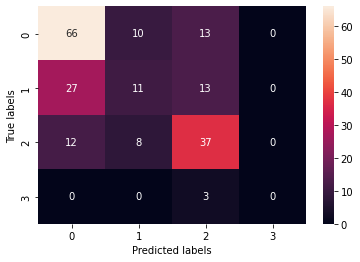

In [ ]:
sns.heatmap(confusion_matrix(testY2, y_pred2), annot = True, fmt = 'd')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [ ]:
print('Class 0 percentage: ', Percent(trainY2.count('1') / len(trainY2)))
print('Class 1 percentage: ', Percent(trainY2.count('2') / len(trainY2)))
print('Class 2 percentage: ', Percent(trainY2.count('3') / len(trainY2)))
print('Class 3 percentage: ', Percent(trainY2.count('4') / len(trainY2)))

Class 0 percentage:  29.15%
Class 1 percentage:  19.24%
Class 2 percentage:  22.46%
Class 3 percentage:  29.15%


In [ ]:
counter5 = 1
for i in range(len(testY)):
  if testY[i] == '4' and y_pred[i] == '3':
    print(str(counter5) + ". " + testX[i])
    counter5 += 1

1. True love or not, the game must play out, and the fates of everyone involved, from the cast of extraordinary circus performers to the patrons, hang in the balance, suspended as precariously as the daring acrobats overhead.

2. To them good ol days exist in pre industrial natural selection world or in some fictional novel.Worst ideologies are those that promises Utopian world. They roads leads to nowhere and are paved with blood."Nirvana is not for this world"

3. In the story, Kate Daniels is a down-on-her-luck mercenary who makes her living cleaning up these magical problems. But when Kate’s guardian is murdered, her quest for justice draws her into a power struggle between two strong factions within Atlanta’s magic



However, even though we increase the sampling of underrepresented class, we haven't seen any changes in the prediction. ***We would infer that in our case resampling cannot promote the performance of our classifier.***

**Part 3: Features Learned to most define the Class**

In [ ]:
'''
The Strongest coefficients for each class are: 
0	0.753	!
0	0.409	i
0	0.244	?
0	0.232	...
0	0.195	me
0	0.170	my
0	0.169	: )
0	0.161	'm
0	0.154	with
0	0.146	na

1	0.236	if
1	0.176	If you 
1	0.176	If you
1	0.175	r/52book
1	0.154	literature
1	0.151	bookclub
1	0.147	maybe
1	0.144	found
1	0.140	then
1	0.139	have

2	0.233	as
2	0.228	by
2	0.228	be
2	0.222	r/truelit
2	0.210	's
2	0.194	.
2	0.182	are
2	0.179	on
2	0.167	/r/truelit
2	0.164	/r/askliterarystudies

3	0.151	but
3	0.150	. But 
3	0.150	. But
3	0.146	love
3	0.142	of
3	0.098	one
3	0.093	dark
3	0.091	world
3	0.087	diaries
3	0.085	her , 
'''

We may explain the strength of some of the features. For example, "!", "?" are signs of strong sentiment and "me", "my" are signs of personal expression, which as we defined in the guidline, are indicators of casualness. Furthermore, "as" can be interpreted as "reasoning" and make sense to be a sign of class 3. More "." indicate a longer text, which would more likely to have detailed explanations and thus higher probability of formalness. Although class 3 has the worst performance among all the classes, the defining features of class 3 is still quite intuitive. "Dark", "world", and "love" are general intangible words that aren't usually used in formal expressions.





However, there're plenty of features that we wouldn't intuitively interpret their strength. "Are" is a singular plural present tense of "be" which seems very prevalent in every kinds of text in real world, but here we only have it as a strong sign of formalness. 

From the features, we also see something we failed to carefully consider when selecting the data. We notice that for class 1, "book", "literature", "r/book" are among the top features of predicative power. This means there is a bias that the post we selected from the r/book thread are full of ordinary posts. Similarly, "r/truelit" and "r/askliterary studies" has a large proportion of formal posts, which makes them as the defining feature of class 2. This phenomenon is against our initial idea of only focusing on text itself in order to grasp the feature of casualness-formalness. We believe changing the span of posts we analyze on (also maybe remove any tags that exist in the post) can solve this issue on some extent.
